# Basic Overview
The idea here is to build xgboost models that are comprised of separate predictors and hence extremely low correlation to each other.

Even if the models are themselves not very powerful in itself, the low correlations between them make them ideal candidates for ensembling.

Comments/criticisms/appreciations are greatly accepted and appreciated.

Source of data : https://www.kaggle.com/c/titanic/data

In [43]:
import pandas as pd
import numpy as np

In [44]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [45]:
# Ha
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [46]:
train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test.csv")

Since XGBoost uses only numeric predictors, and we do not want to increase dimensionality, we will go with numeric encoding for sex and plcass variables for now.

In [47]:
train_data.loc[(train_data['Sex'] == 'male'), 'Sex'] = 1
train_data.loc[(train_data['Sex'] == 'female'), 'Sex'] = 0

test_data.loc[(test_data['Sex'] == 'male'), 'Sex'] = 1
test_data.loc[(test_data['Sex'] == 'female'), 'Sex'] = 0


In [48]:
# Add a column called Predictions in training data, which will become handy while doing
# cross validation.
train_data['Predictions'] = -1

In [49]:
# Since we look to be having lots of entries with cabin field set as null, we make that as a factor and see
# what we can get out of it.
train_data['IsCabinNull'] = train_data['Cabin'].isnull()
test_data['IsCabinNull'] = test_data['Cabin'].isnull()

In [50]:
from sklearn.preprocessing import Imputer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

In [51]:
def get_train_test_data(train_data,
                        X_columns=['Sex', 'Pclass', 'Age'], 
                        Y_columns=['Survived']):
    # Simple training and testing
    X = train_data[X_columns]
    Y = train_data[Y_columns]

    X_one_hot = pd.get_dummies(X)

    # Do imputation on relevant columns.
    X_train, X_test, Y_train, Y_test = train_test_split(X_one_hot, Y, random_state=0)

    return (X_train, X_test, Y_train, Y_test, X_one_hot, Y)


In [52]:
def create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test, n_estimators=100, 
                                            learning_rate=0.1):
    # Rewrite everything as a pipeline
    my_pipeline = make_pipeline(Imputer(), 
                                XGBClassifier(seed=1, n_estimators=n_estimators, learning_rate=learning_rate))
    my_pipeline.fit(X_train, Y_train.values.ravel())
    predictions = my_pipeline.predict(X_test)
    out_of_sample_score = 1.0 - mean_absolute_error(predictions, Y_test)
    return (my_pipeline, out_of_sample_score, predictions)

In [53]:
def cross_validate(my_pipeline, X_one_hot, Y):
    cross_val_scores = cross_val_score(my_pipeline, X_one_hot, Y, scoring='neg_mean_absolute_error', cv=5)
    return 1.0  + cross_val_scores.mean()

In [54]:
def train_test_cross_validate(train_data, 
                              X_columns=['Sex', 'Pclass', 'Age'], 
                              Y_columns=['Survived'],
                              n_estimators=100,
                              learning_rate=0.1):
    (X_train, X_test, Y_train, Y_test, X_one_hot, Y) = get_train_test_data(train_data, X_columns, Y_columns)
    my_pipeline, out_of_sample_score, predictions_test = \
        create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test, n_estimators, learning_rate)

    print("Number of entries in training set is {0}".format(len(X_train)))
    predictions_train = my_pipeline.predict(X_train)
    num_correct_predictions_train = int((1.0 - mean_absolute_error(predictions_train, Y_train)) * len(Y_train))


    print("Number of correct predictions in training set is {0}".format(num_correct_predictions_train))    
    print("Number of entries in test set is {0}".format(len(X_test)))    
    print("Number of correct predictions in test set is {0}".format(int(out_of_sample_score * len(X_test))))

    cross_validation_score = cross_validate(make_pipeline(Imputer(), 
                                                          XGBClassifier(seed=1,
                                                                        n_estimators=n_estimators, 
                                                                        learning_rate=learning_rate)), 
                                            X_one_hot, Y.values.ravel())
    return (my_pipeline, out_of_sample_score, cross_validation_score)

In [55]:
# Make sure that unnecessary deprecation warnings are avoided.
# Thanks to https://stackoverflow.com/questions/49545947/sklearn-deprecationwarning-truth-value-of-an-array
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


### Correlation between predictors. 

In [56]:
train_data[['Survived', 'Pclass', 'Age', 'Sex']].corr()

,Survived,Pclass,Age,Sex
Survived,1.000000,-0.338481,-0.077221,-0.543351
Pclass,-0.338481,1.000000,-0.369226,0.131900
Age,-0.077221,-0.369226,1.000000,0.093254
Sex,-0.543351,0.131900,0.093254,1.000000


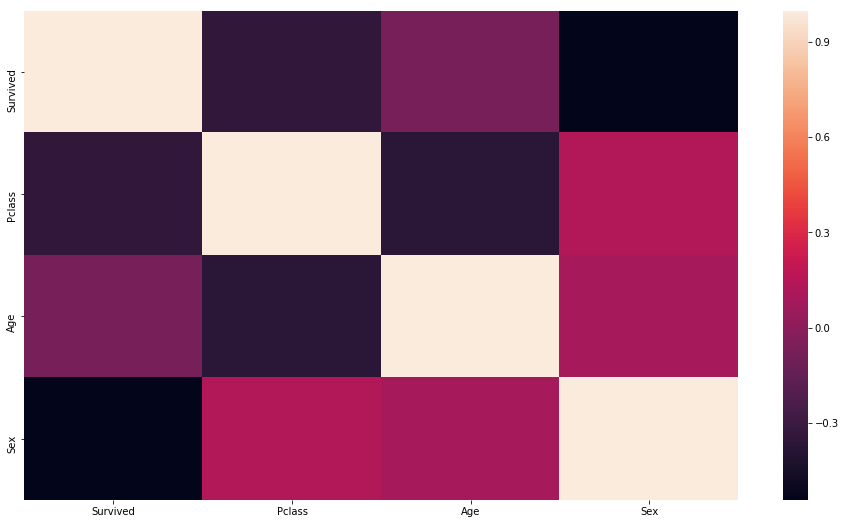

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.heatmap(train_data[['Survived', 'Pclass', 'Age', 'Sex']].corr(), ax=ax)

The correlation level looks acceptable here.

In [58]:
# Get the XGBclassifier directly as it is far easier to visualize this than the
# pipeline object.
def get_sklearn_xgbclassifier(train_data, X_columns=['Sex'], Y_columns=['Survived']):
    my_model = XGBClassifier(seed=1)
    X_train = train_data[X_columns]
    Y_train = train_data[Y_columns]
    my_model.fit(X_train, Y_train.values.ravel())    
    return my_model

In [59]:
def get_gridsearch_crossval_output(train_data, 
                                   X_columns = ['Sex', 'Pclass'], 
                                   Y_columns = ['Survived'],
                                   n_estimators_list = [10, 50, 70, 100, 120, 150, 200],
                                   learning_rates_list = [0.01, 0.02, 0.05, 0.07, 0.1],
                                   early_stopping_round = 10,
                                   num_cross_val_sets = 5
                                  ):
    (X_train, X_test, Y_train, Y_test, X_one_hot, Y) = get_train_test_data(train_data, X_columns, Y_columns)
    col_names = ['f' + str(i) for i in range(len(X_train.columns))]
    X_train.columns = col_names
    X_test.columns = col_names
    my_pipeline = Pipeline([('imputer', Imputer()), ('xgcl', XGBClassifier())])
    param_grid = {
        'xgcl__n_estimators' : n_estimators_list,
        'xgcl__learning_rate' : learning_rates_list
    }
    fit_params = {'xgcl__eval_set' : [(X_test, Y_test.values.ravel())],
                  'xgcl__early_stopping_rounds' : early_stopping_round,
                  'xgcl__verbose': False}

    searchCV = GridSearchCV(my_pipeline, cv=num_cross_val_sets, param_grid=param_grid, fit_params=fit_params)
    searchCV.fit(X_train, Y_train.values.ravel())
    return searchCV

In [60]:
def get_model_metrics_and_display(train_data, X_columns=['Sex'], Y_columns=['Survived']):
    (my_pipeline, out_of_sample_score, cross_validation_score) = \
        train_test_cross_validate(train_data,
                                  X_columns, 
                                  Y_columns)

    print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))
    my_model = get_sklearn_xgbclassifier(train_data, X_columns, Y_columns)
    return my_model
    

### Model 1: IsCabinNull as the predictor

#### Basic training/cross validation

In [61]:
X_columns = ['IsCabinNull']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 457
Number of entries in test set is 223
Number of correct predictions in test set is 160
Out of sample score is 0.7174887892376682
Cross val score is 0.6925897239756053


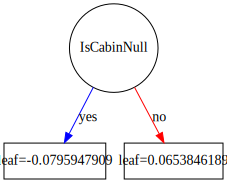

In [62]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


### Model 2: Parch, SibSp,Embarked as predictors.

#### Analysis of Embarked variable

In [63]:
# Remove the nans from the training data before analysis.
train_data_new = pd.get_dummies(train_data[train_data['Embarked'].notnull()])
test_data_new = pd.get_dummies(test_data[test_data['Embarked'].notnull()])

In [64]:
train_data_new.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Predictions', 'IsCabinNull',
       ...
       'Cabin_F G73', 'Cabin_F2', 'Cabin_F33', 'Cabin_F38', 'Cabin_F4',
       'Cabin_G6', 'Cabin_T', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object', length=1728)

Comment : It can be seen that since Embarked is a categorical variable, we will be forced to add in 2 variables (there are 3 values for this variable, hence we can represent this with 2 variables).

However, since we want to keep dimensonality as low as possible, we will try to see the 'density' of the values of this variable and check if we can manage with one variable itself.

In [65]:
train_data_new[['Embarked_C']].describe()

,Embarked_C
count,889.000000
mean,0.188976
std,0.391710
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [66]:
train_data_new[['Embarked_Q']].describe()

,Embarked_Q
count,889.000000
mean,0.086614
std,0.281427
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [67]:
train_data_new[['Embarked_S']].describe()

,Embarked_S
count,889.000000
mean,0.724409
std,0.447063
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


Comments : It can be easily seen that 'S' is the major embarking point and hence let us use only that as our predictor for now(as far as 'Embarked' variable is concerned).

#### Basic training/cross validation

In [68]:
X_columns = ['Parch', 'SibSp', 'Embarked_S']
Y_columns = ['Survived']

Number of entries in training set is 666
Number of correct predictions in training set is 462
Number of entries in test set is 223
Number of correct predictions in test set is 150
Out of sample score is 0.6726457399103138
Cross val score is 0.6850822065638291


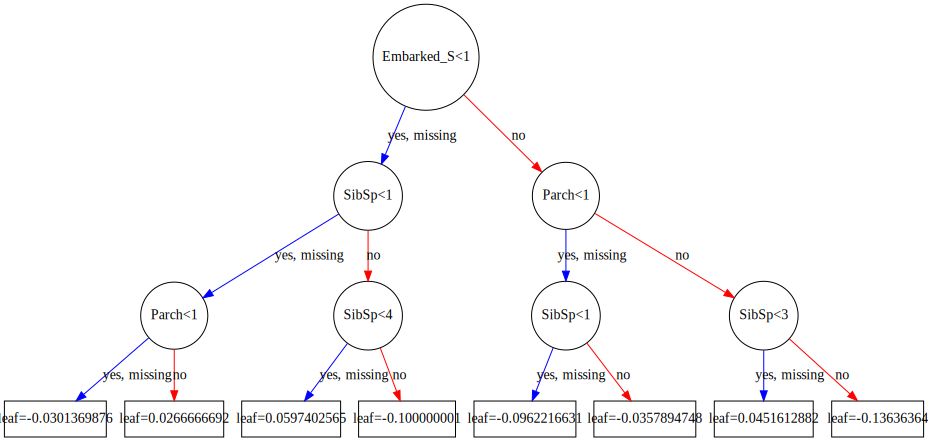

In [69]:
my_model = get_model_metrics_and_display(train_data_new,X_columns=X_columns)
xgb.to_graphviz(my_model)


Comment : Though these models do not perform as well as the ones we had seen earlier, they could still be useful as a third model for ensembling (since they are extremely likely to have very small correlation with our earlier models).

Let us generate ouptut files on out of sample data and see how correlated these are, to each other. 

#### Creating a file with predictions on out of sample data for Model 1

In [70]:
#create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test)
X_columns = ['IsCabinNull']
Y_columns = ['Survived']
X_train = train_data[X_columns]
X_train_one_hot = pd.get_dummies(X_train)
Y_train = train_data[Y_columns]
X_test = test_data[X_columns]
X_test_one_hot = pd.get_dummies(X_test)

# Create a dummy test data s
Y_test = np.ones(len(test_data[X_columns])) * -1
(my_pipeline, out_of_sample_score, predictions_out_of_sample) = \
    create_pipeline_and_out_of_sample_score(X_train_one_hot, 
                                            X_test_one_hot,
                                            Y_train,
                                            Y_test,
                                            1,
                                            0.01)
test_data['Predictions'] = predictions_out_of_sample
kaggle_data = test_data[['PassengerId', 'Predictions']].copy()
kaggle_data.rename(columns={'Predictions' : 'Survived'}, inplace=True)
kaggle_data.sort_values(by=['PassengerId']).to_csv('kaggle_out_xgboost_cabin_null.csv', index=False)

#### Creating a file with predictions on out of sample data for Model 2

In [71]:
#create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test)
X_columns = ['Parch', 'SibSp', 'Embarked_S']
Y_columns = ['Survived']
X_train = train_data_new[X_columns]
X_train_one_hot = pd.get_dummies(X_train)
Y_train = train_data_new[Y_columns]
X_test = test_data_new[X_columns]
X_test_one_hot = pd.get_dummies(X_test)

# Create a dummy test data s
Y_test = np.ones(len(test_data_new[X_columns])) * -1
(my_pipeline, out_of_sample_score, predictions_out_of_sample) = \
    create_pipeline_and_out_of_sample_score(X_train_one_hot, 
                                            X_test_one_hot,
                                            Y_train,
                                            Y_test,
                                            1,
                                            0.01)
test_data['Predictions'] = predictions_out_of_sample
kaggle_data = test_data[['PassengerId', 'Predictions']].copy()
kaggle_data.rename(columns={'Predictions' : 'Survived'}, inplace=True)
kaggle_data.sort_values(by=['PassengerId']).to_csv('kaggle_out_xgboost_parch_sibsp_embarked_s.csv', index=False)

#### Check correlation of predictions on out of sample data

In [72]:
predictions_models_df = pd.read_csv('kaggle_out_cabin_null.csv')
predictions2 = pd.read_csv('kaggle_out_parch_sibsp_embarked_s.csv')
predictions_models_df.rename(columns={'Survived' : 'Survived_1'}, inplace=True)
predictions_models_df['Survived_2'] = predictions2['Survived']

print(predictions_models_df.columns)
display(predictions_models_df[['Survived_1', 'Survived_2']].corr())

Index(['PassengerId', 'Survived_1', 'Survived_2'], dtype='object')


,Survived_1,Survived_2
Survived_1,1.000000,0.207858
Survived_2,0.207858,1.000000


Comments : This looks promising, as we have only 20% correlation between predictions.